# Pin to core

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statistics as stat
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
from toolstats import KW_test

def get_median(df):
    try:
        return stat.median(df.values)
    except:
        return np.nan

def get_ci(s,  alpha=0.95, p=0.5, n_thresh=10):
    n = len(s)
    q = np.quantile(s, p)
    eta = stats.norm.ppf((1+alpha)/2.0) # 1.96 for alpha = 0.95
    lo_rank = max(int(np.floor(n * p - eta * np.sqrt(n * p * (1-p)))), 0)
    hi_rank = min(int(np.ceil(n * p + eta * np.sqrt(n * p * (1-p))) + 1), n-1)
    s_sorted = sorted(s.tolist())
    q_ci_lo = s_sorted[lo_rank]
    q_ci_hi = s_sorted[hi_rank]
    return [q_ci_lo, q_ci_hi]

def expand_stream_result(df_mem):
    def to_float_list(s):
        list_ = [float(x) for x in s.split(',')]
        if len(list_) == 1:
            return list_[0]
        else:
            return list_

    df_mem['result'] = df_mem['result'].apply(to_float_list)
    df = pd.DataFrame()
    tests = ['copy_omp','scale_omp','add_omp', 'triad_omp']
    for index, row in df_mem.iterrows():
        results = row['result']
        id = row['test_command']
        for i,r in enumerate(results):
            temp = row.copy()
            temp['result'] = r
            temp['benchmark'] = tests[i]
            df = df.append(temp)
    return df

In [2]:
stream_stats_file = "stream_perf.csv"
results_file = "20220307_18:31:02_all_test_results.csv"

interesting_columns = ['cache-misses','cache-references','branch-misses','mem-stores','LLC-load-misses',
                       'L1-dcache-load-misses','L1-icache-load-misses','dTLB-load-misses','dTLB-store-misses',
                       'page-faults','context-switches','cpu-migrations','major-faults','minor-faults',
                       'branch-load-misses','iTLB-load-misses']

perf_stats_all = pd.read_csv(stream_stats_file)[interesting_columns + ['order_type']]
results_all = pd.read_csv(results_file)
perf_stats_all = perf_stats_all.join(pd.DataFrame(results_all[results_all["test_command"].str.contains("memory")][['result','test_command']]).reset_index(drop=True))
perf_stats_all = expand_stream_result(perf_stats_all)

perf_stats_random={}
perf_stats_fixed={}
for benchmark in ['copy_omp','scale_omp','add_omp', 'triad_omp']:
    perf_stats_random[benchmark] = perf_stats_all[(perf_stats_all["order_type"]=="random") & (perf_stats_all["benchmark"]==benchmark)]
    perf_stats_fixed[benchmark]  = perf_stats_all[(perf_stats_all["order_type"]=="fixed") & (perf_stats_all["benchmark"]==benchmark)]

pd.set_option("display.max_rows", None)
# display(HTML("<div style='height: 600px; overflow: auto; width: fit-content'>" +
#              perf_stats_all.style.render() +
#              "</div>"))

display(HTML("<div style='height: 400px'>" + perf_stats_all.style.render() + "</div>"))

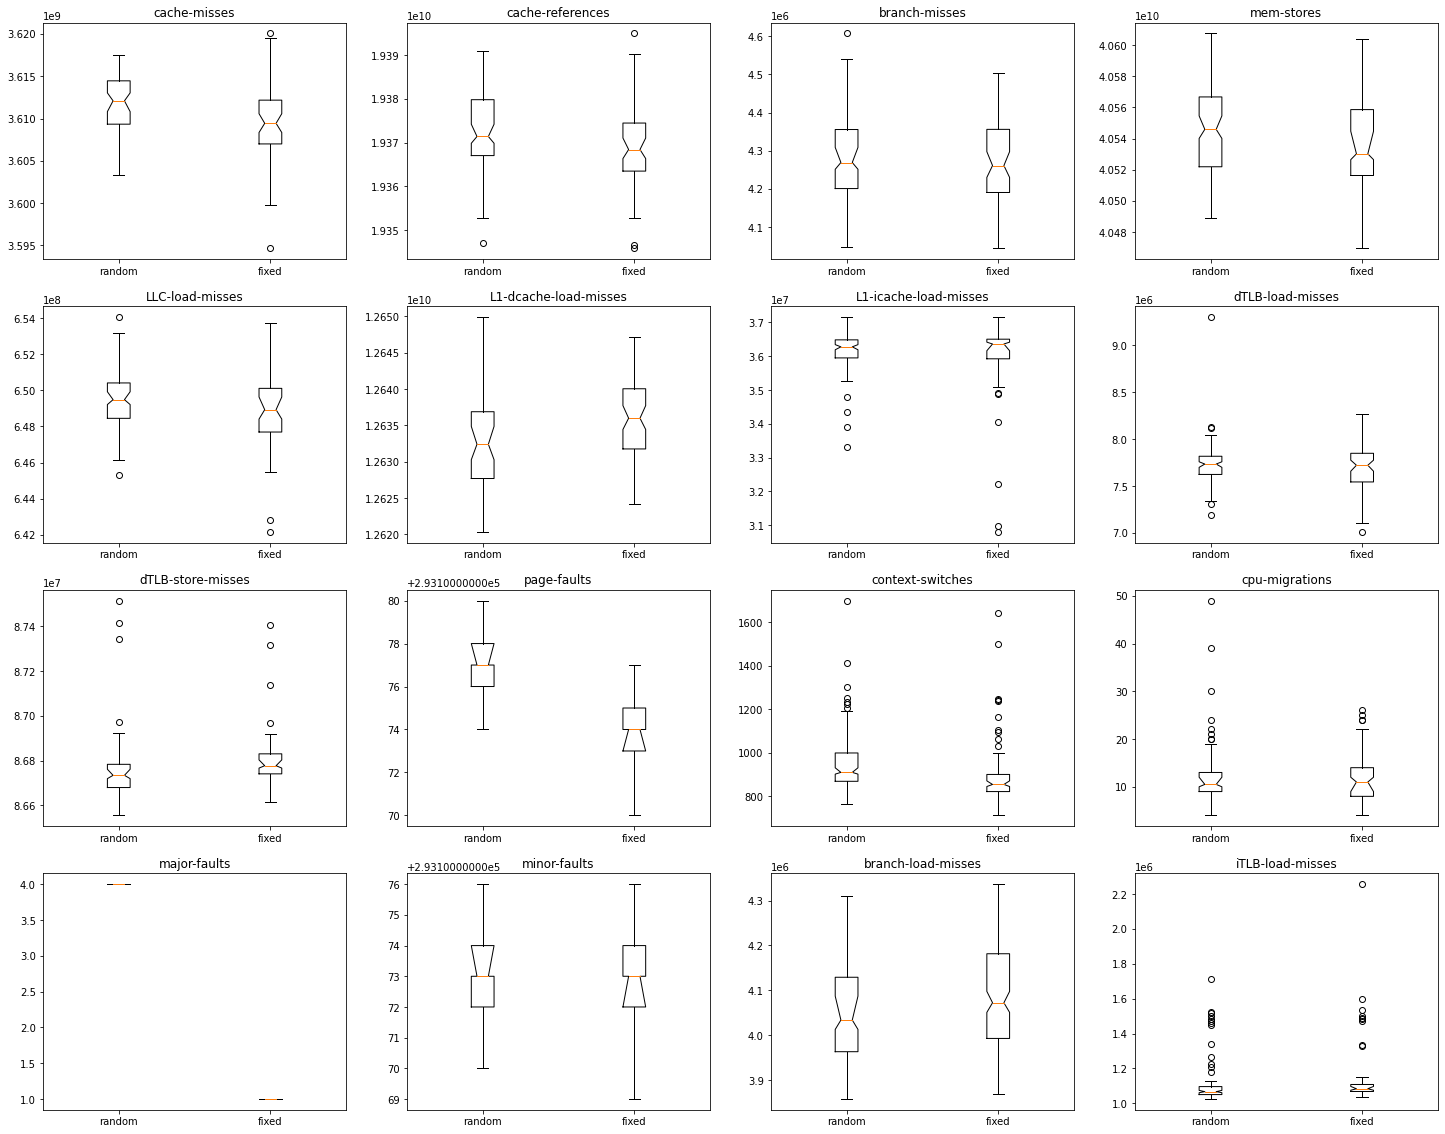

In [3]:
benchmark = "triad_omp"

fig, ax = plt.subplots(4,4)
fig.set_size_inches(25, 20)
for row in range(4):
    for col in range(4):
        column_number=(4*row)+col
        ax[row,col].set_title(interesting_columns[column_number])            
        conf_intervals=[get_ci(perf_stats_random[benchmark][interesting_columns[column_number]]), 
                get_ci(perf_stats_fixed[benchmark][interesting_columns[column_number]])]
        _ = ax[row,col].boxplot([perf_stats_random[benchmark][interesting_columns[column_number]],
                     perf_stats_fixed[benchmark][interesting_columns[column_number]]], notch=True,
                   labels=["random", "fixed"],conf_intervals=conf_intervals)

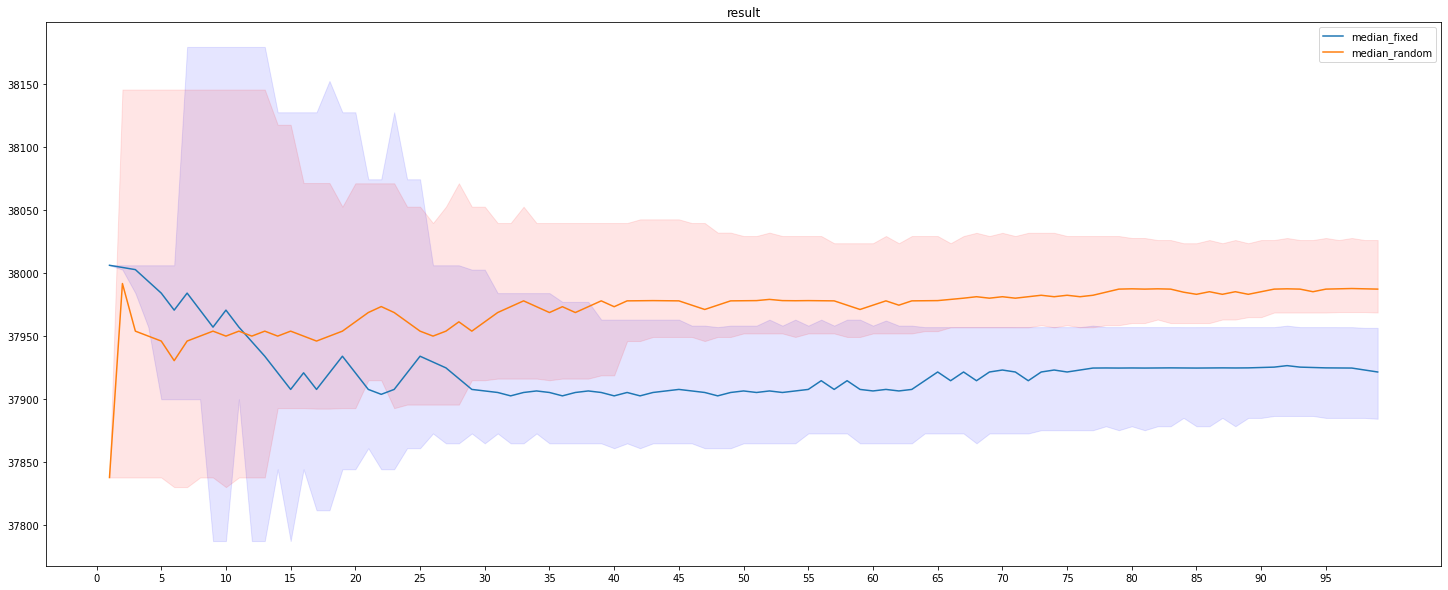

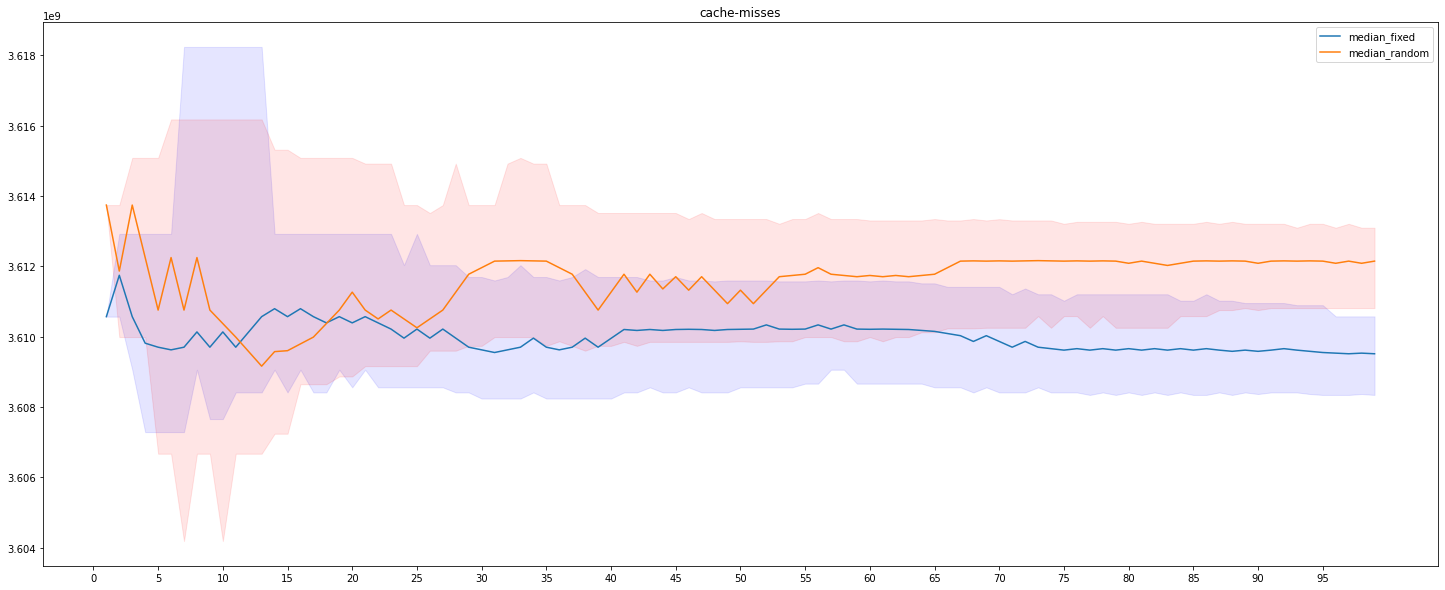

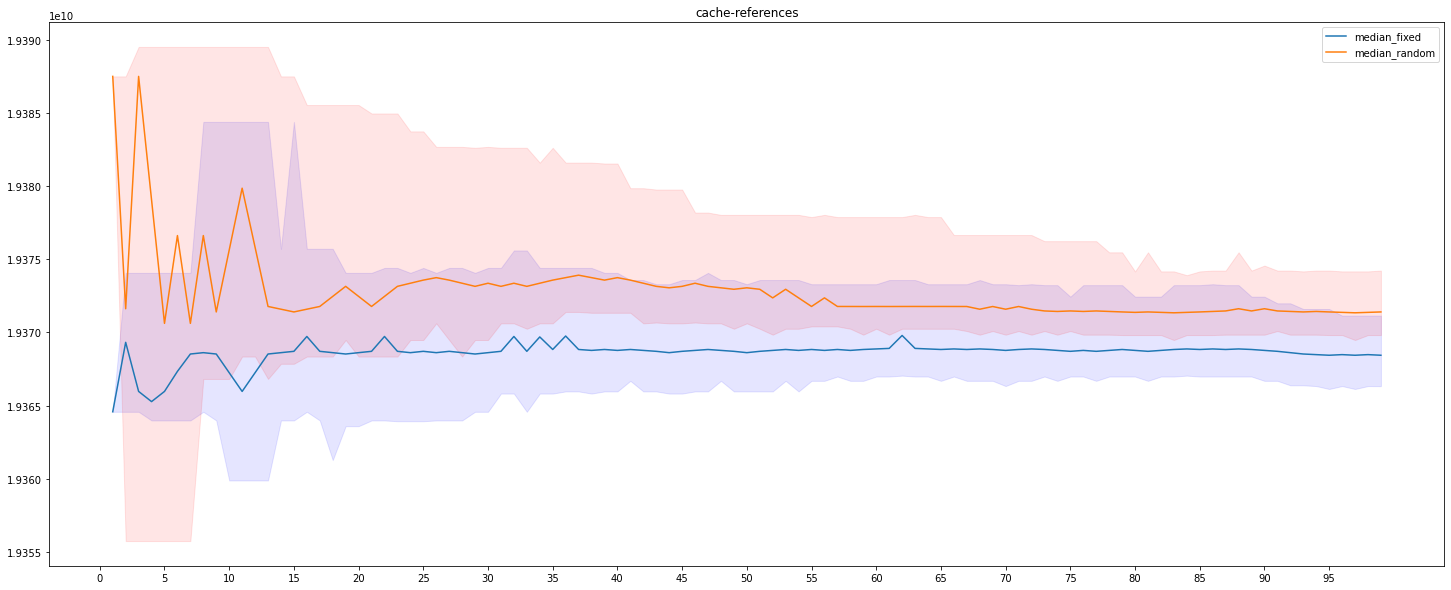

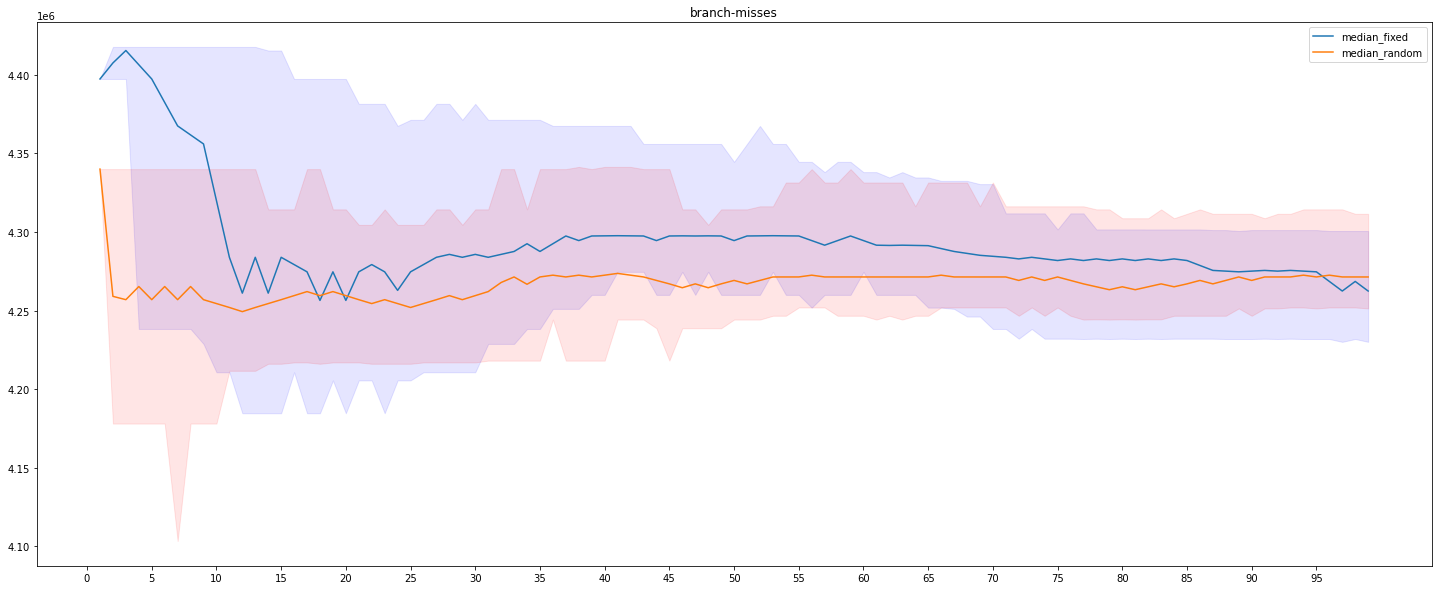

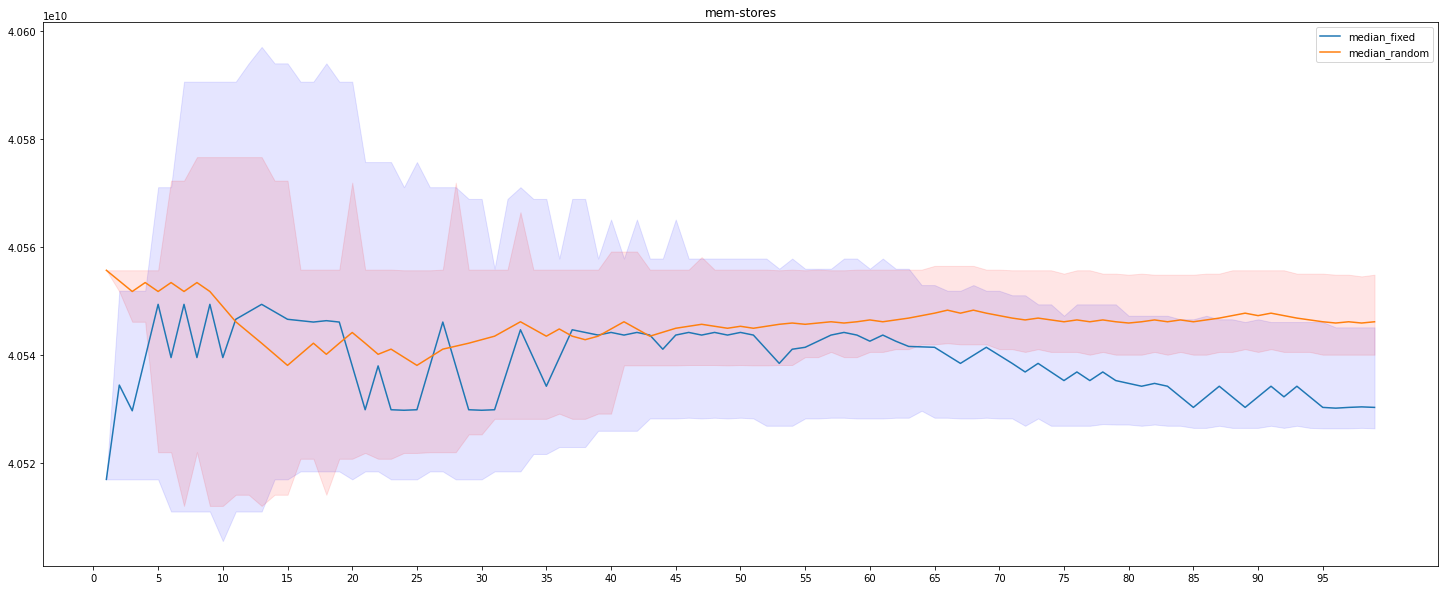

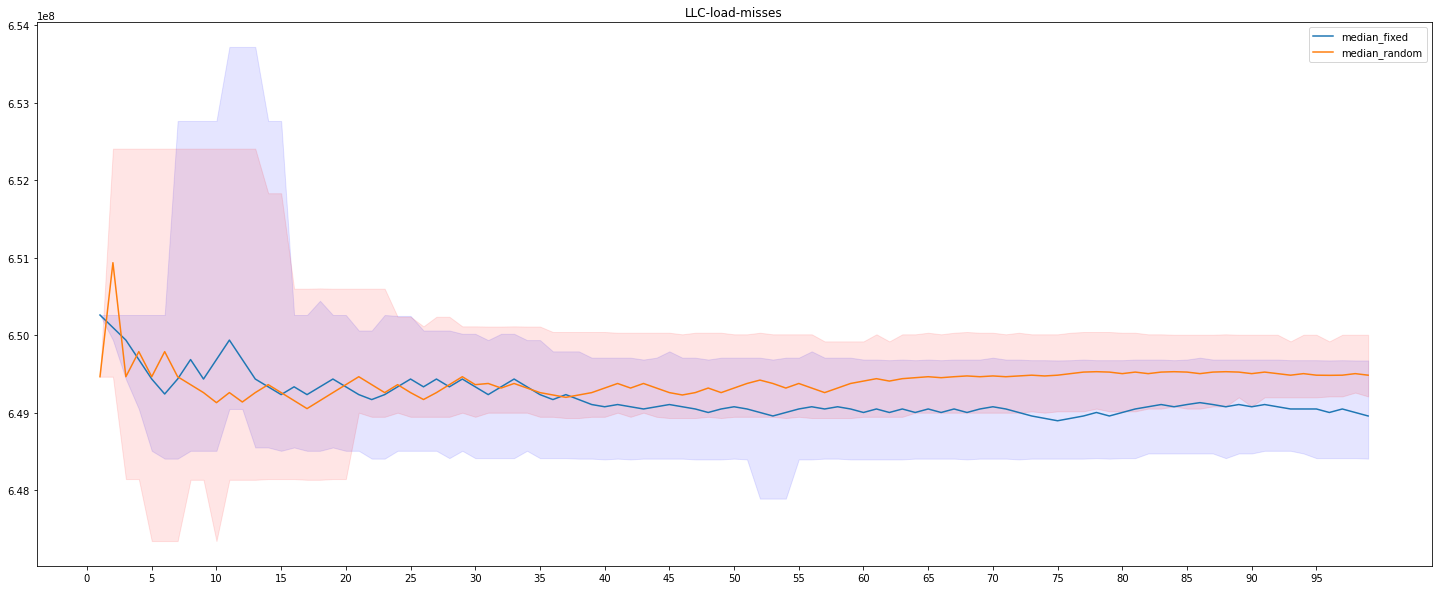

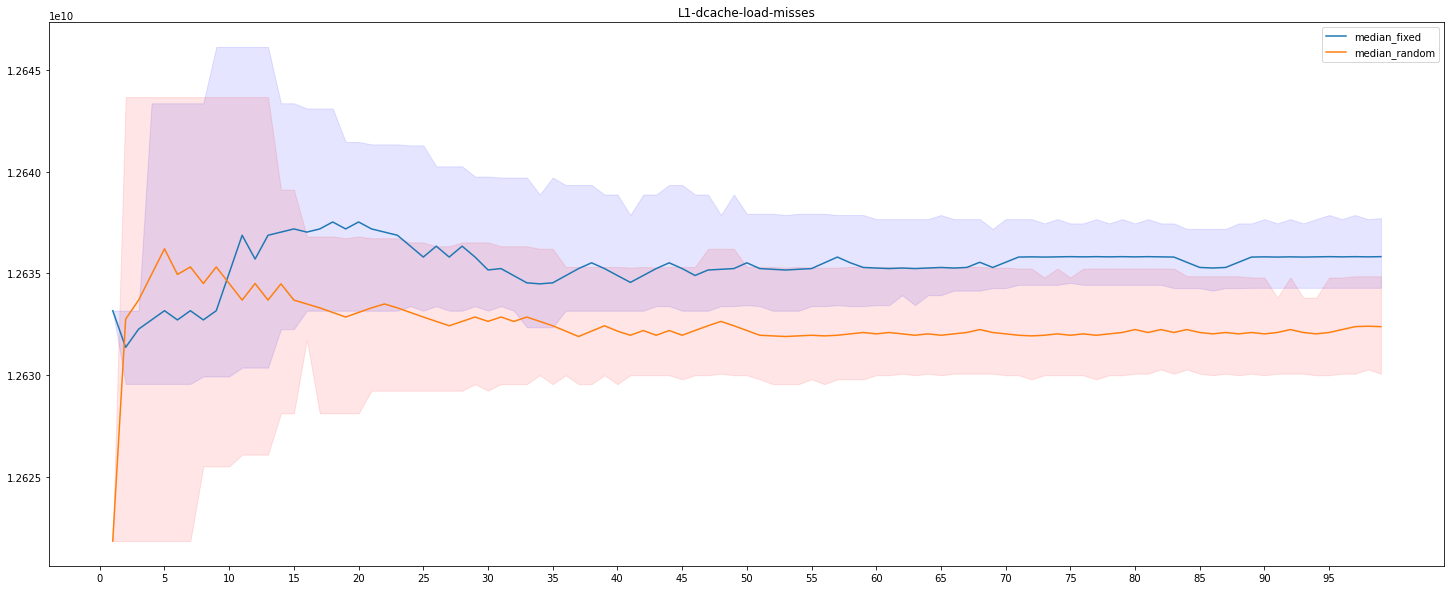

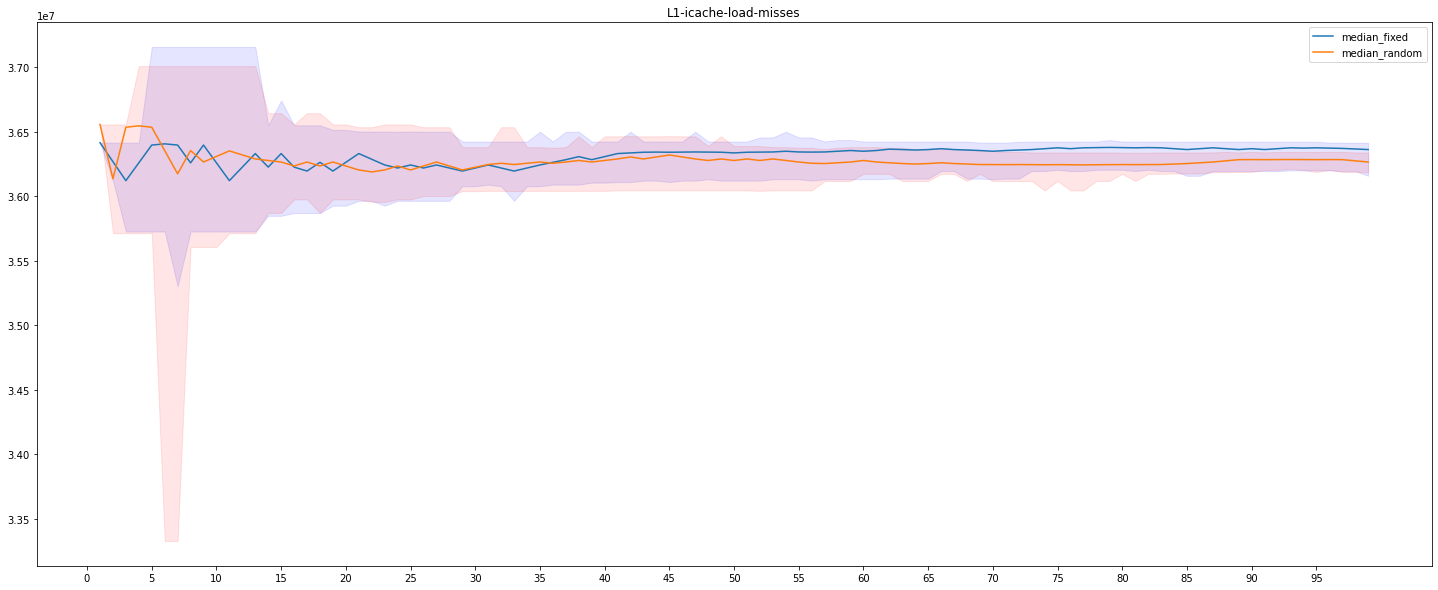

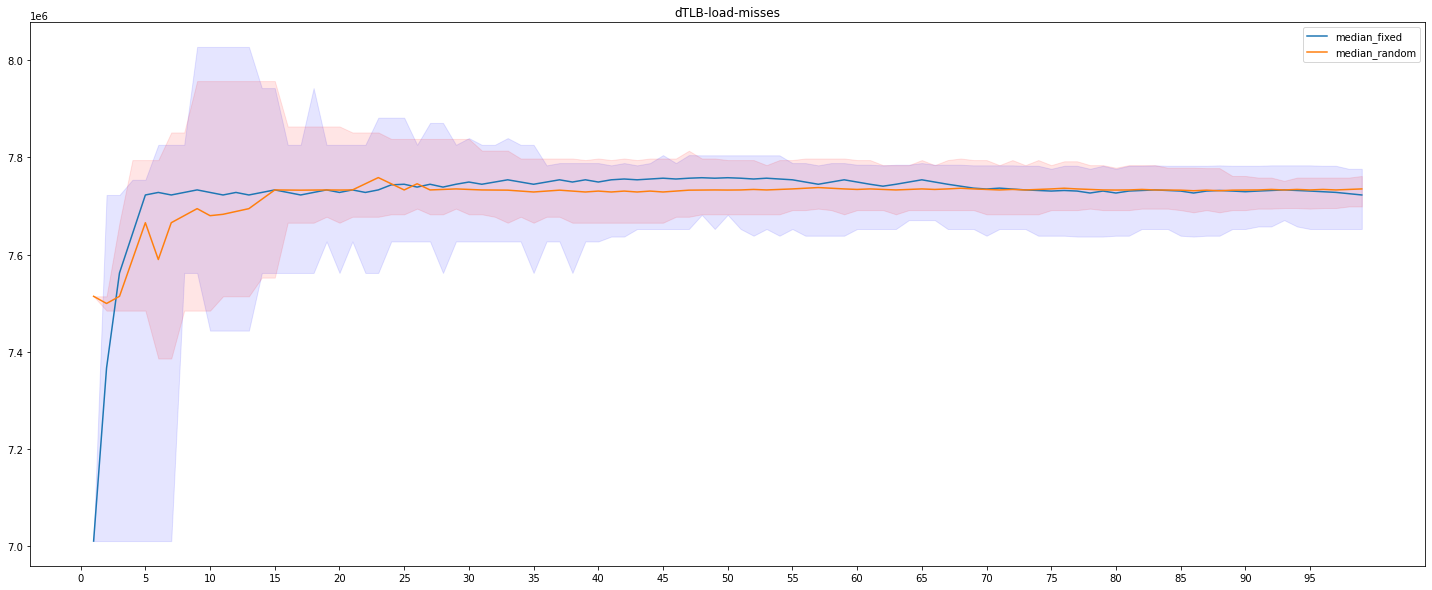

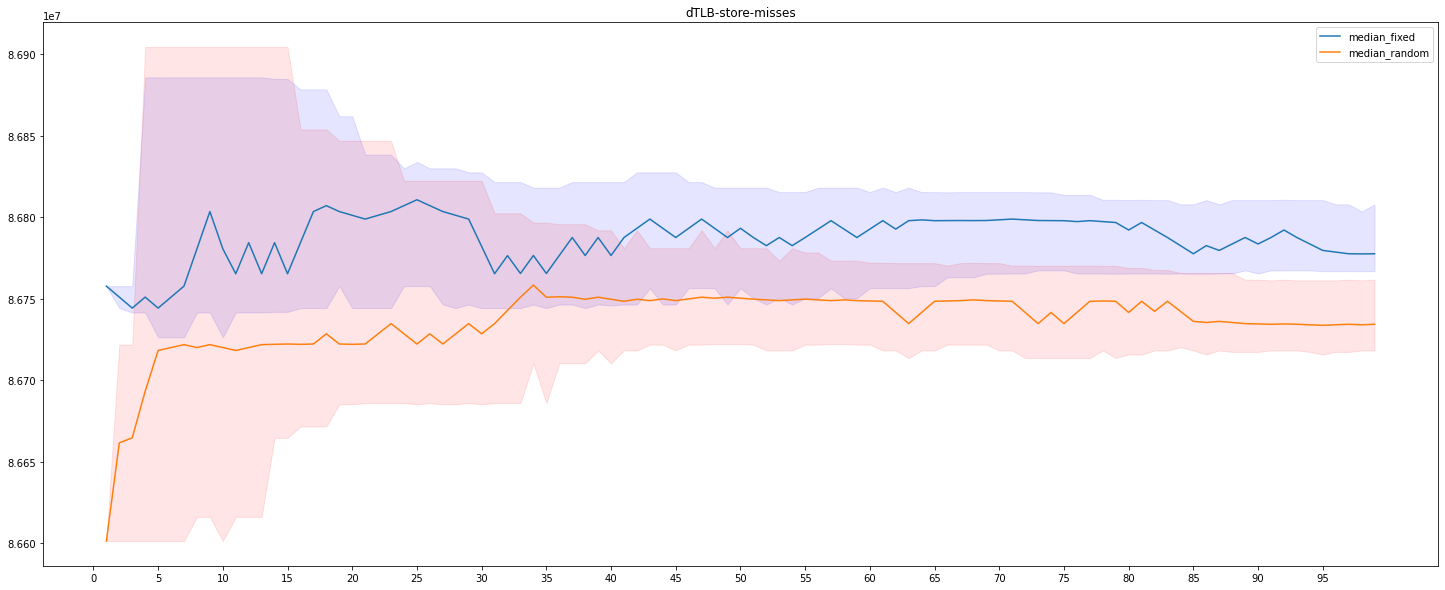

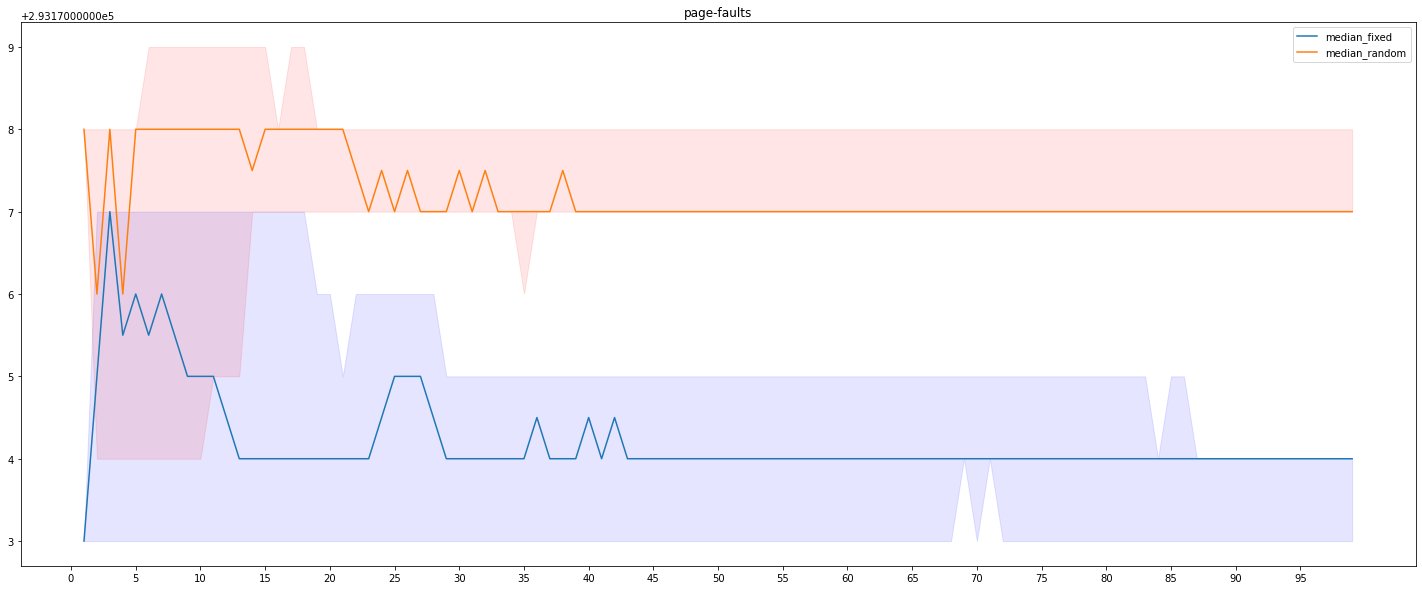

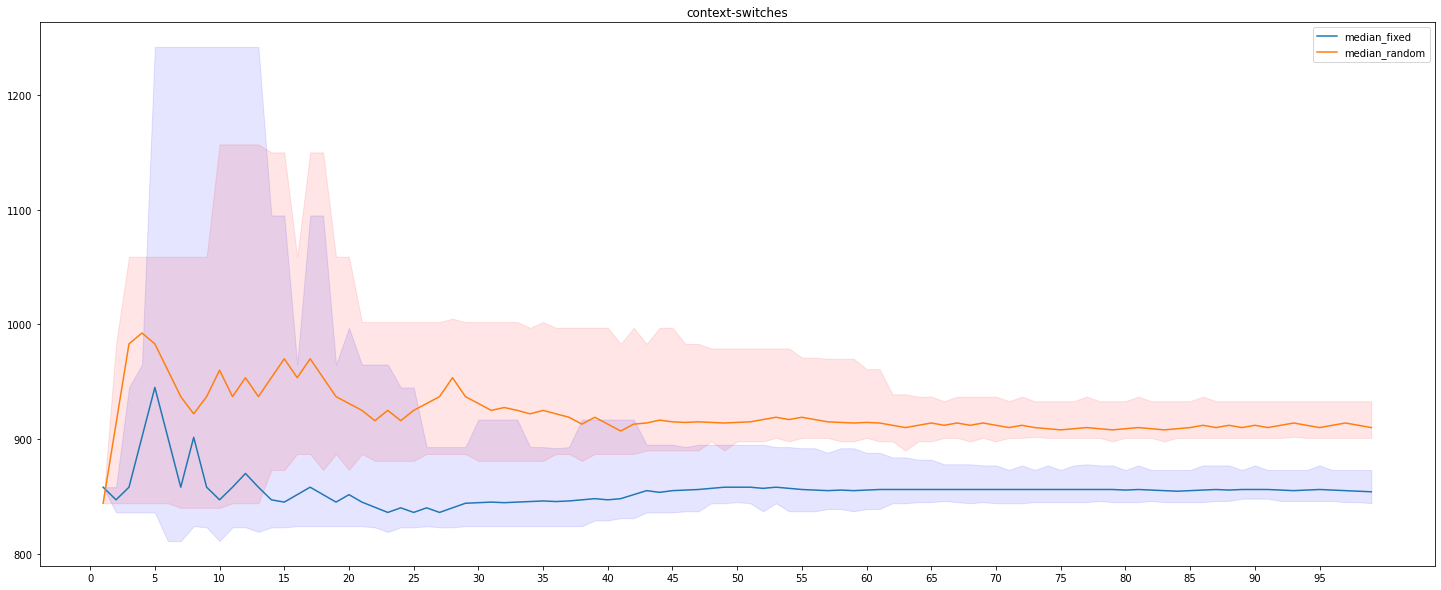

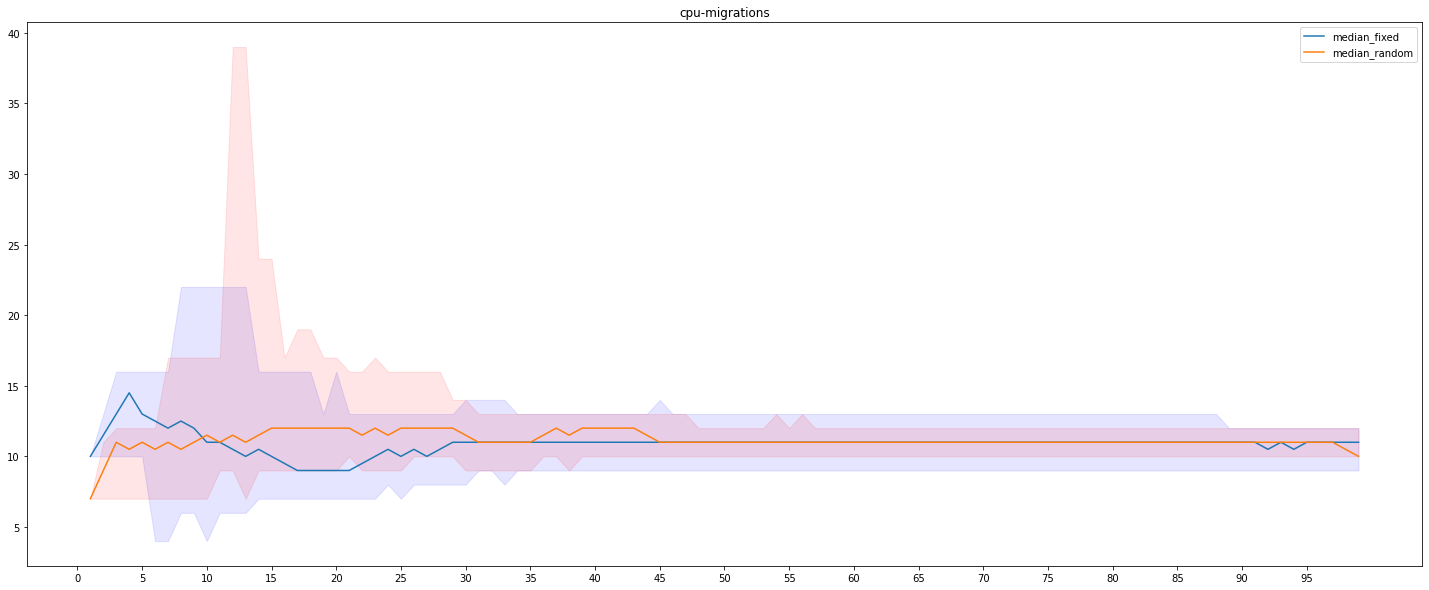

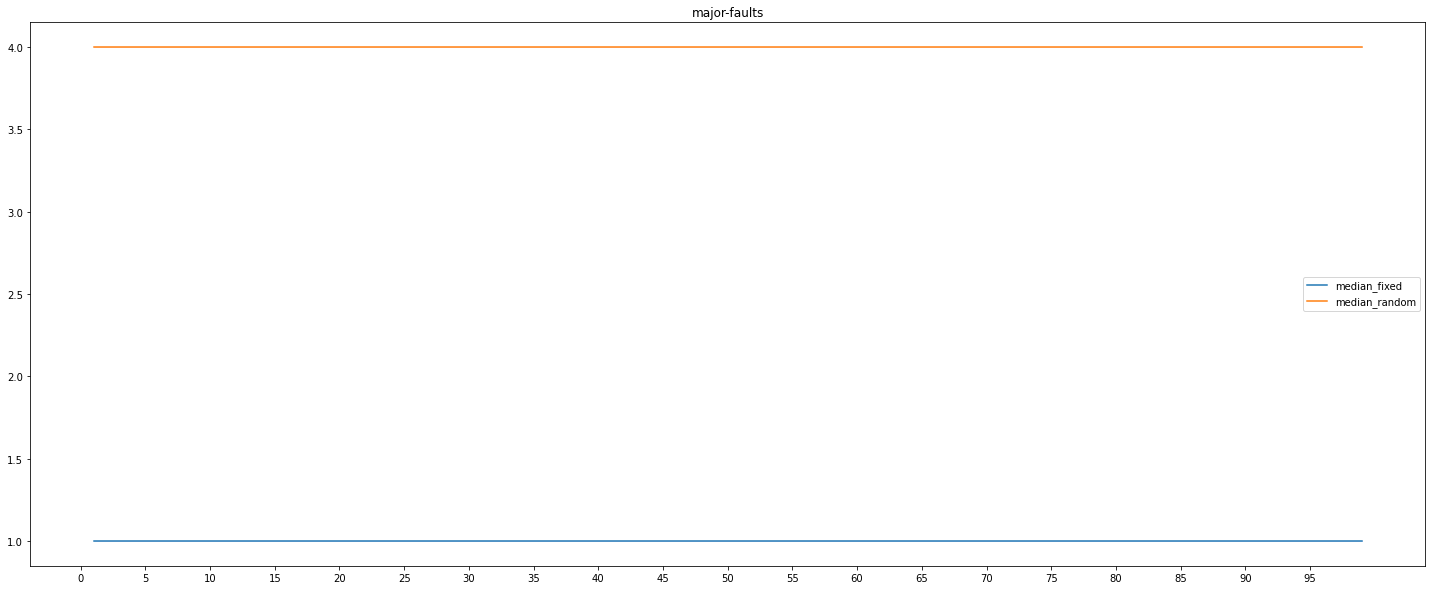

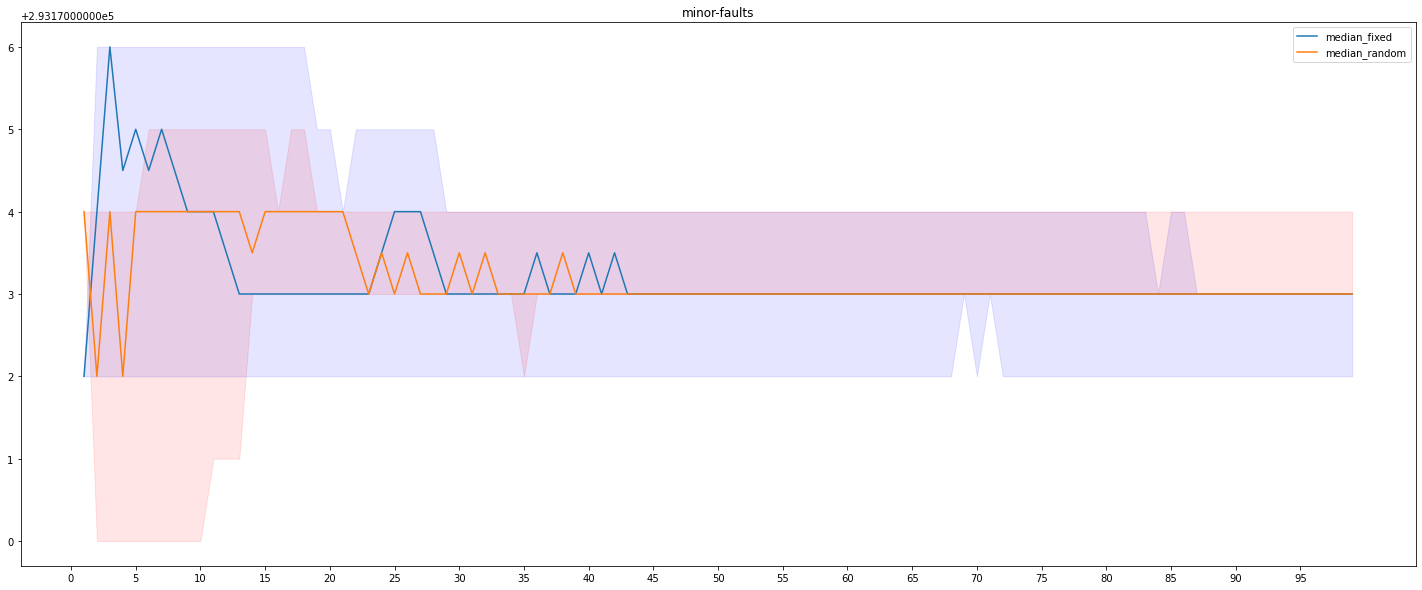

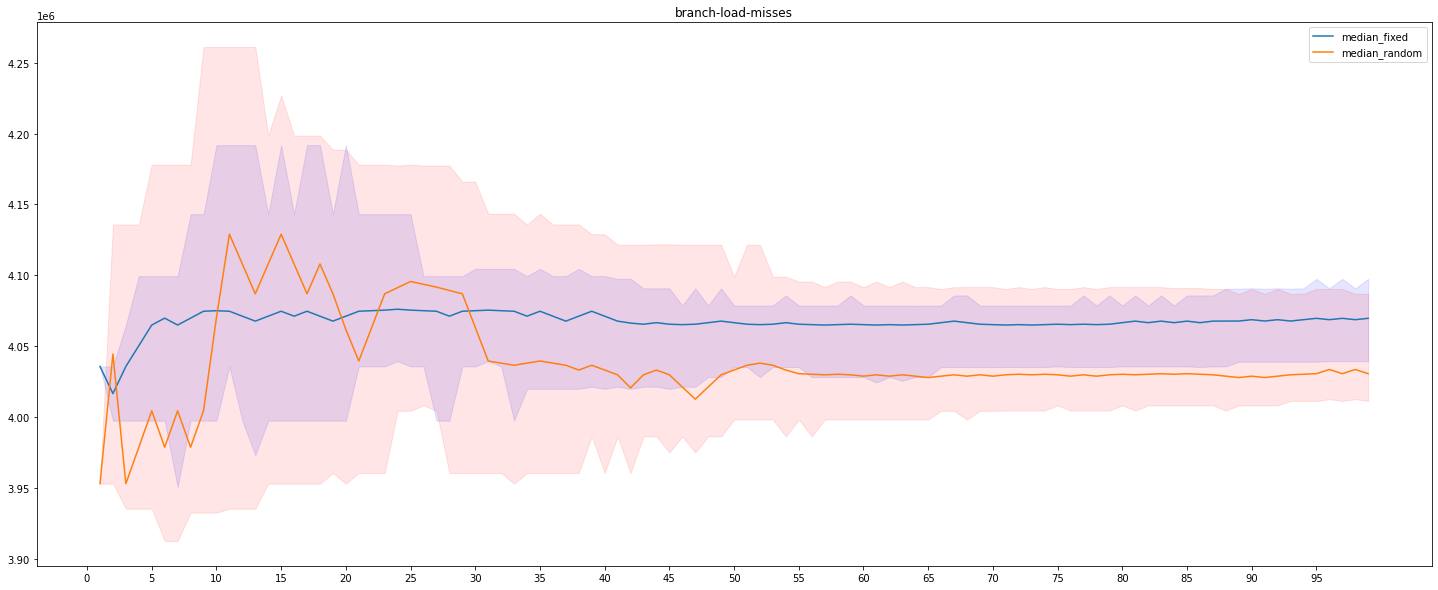

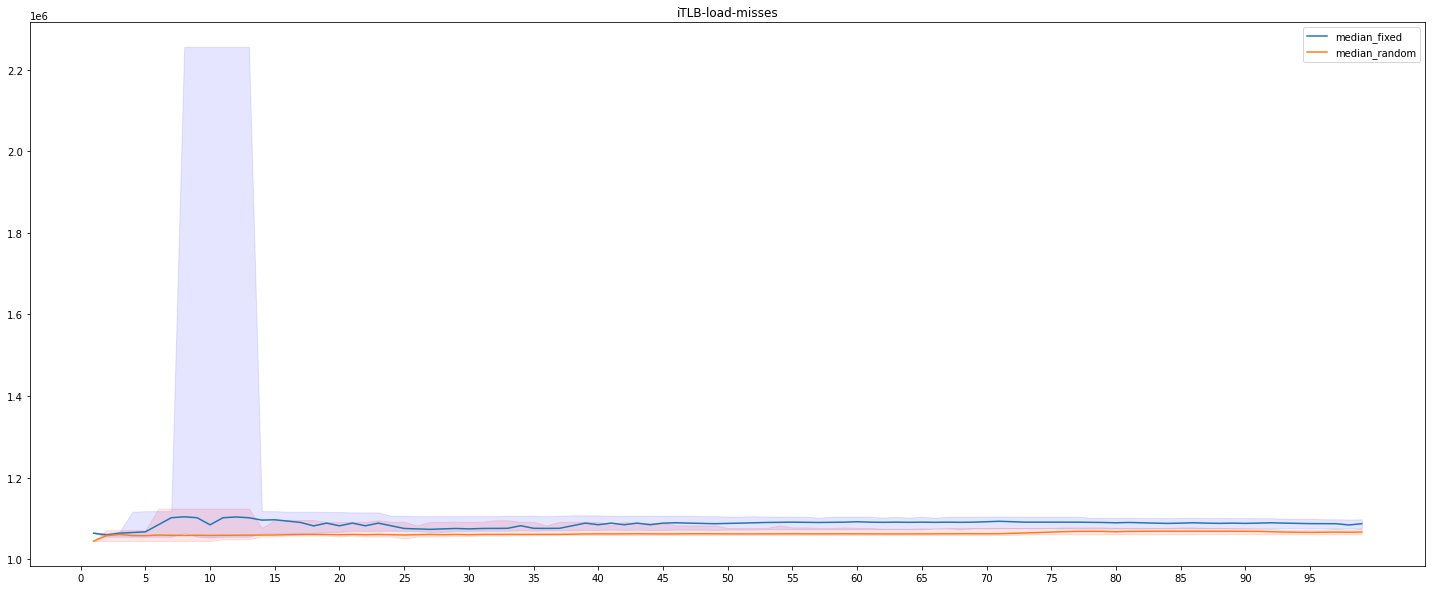

In [4]:
def aggregate_results(df, column_name):
    agg_stats = pd.DataFrame(columns = ['order_type',
                                        'run_num',
                                        'result',
                                        'median_cmltv',
                                        'ci_hi_cmltv',
                                        'ci_lo_cmltv'])

    for idx, group in df.groupby(['order_type']):
        for i in range(1,len(group)):
            result = group.iloc[i][column_name]
            agg_result = group.iloc[:i][column_name]
            med = get_median(agg_result)
            ci_lo,ci_hi = get_ci(agg_result)
            agg_stats.loc[len(agg_stats)] = [idx] + [float(i), result, med, ci_hi, ci_lo]

    return agg_stats

def plot(df, title, plot_actual=False):
    f = df[df['order_type'] == 'fixed']
    r = df[df['order_type'] == 'random']

    plt.figure(figsize=(25,10))
    plt.title(title)
    plt.plot(f['run_num'], f['median_cmltv'], label='median_fixed')
    plt.plot(r['run_num'], r['median_cmltv'], label='median_random')
    if plot_actual:
        plt.plot(f['run_num'], f['result'], label='value_fixed')
        plt.plot(r['run_num'], r['result'], label='value_random')
    plt.fill_between(f['run_num'], f['ci_lo_cmltv'], f['ci_hi_cmltv'],
                     color='b', alpha=.1)
    plt.fill_between(r['run_num'], r['ci_lo_cmltv'], r['ci_hi_cmltv'],
                     color='r', alpha=.1)
    plt.xticks(list(range(0,100,5)))
    plt.legend()
    plt.show()
        
benchmark = "add_omp"

for column_name in ["result"] + interesting_columns:
    cumulative = aggregate_results(perf_stats_all[perf_stats_all['benchmark']==benchmark], column_name)
    plot(cumulative, column_name)

In [5]:
for datapoint in ["result"] + interesting_columns:
    kruskal_wallace = KW_test(perf_stats_all, "result", ['benchmark'])
    display(HTML("<div style='height: 100px'>" + kruskal_wallace.style.render() + "</div>"))